In [2]:
!nvidia-smi

Sat May 15 16:33:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0  On |                  N/A |
| 32%   57C    P2    57W / 250W |    679MiB / 11175MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3080    Off  | 00000000:0A:00.0 Off |                  N/A |
| 53%   

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dense, BatchNormalization, Dropout, MaxPool2D as MaxPooling2D, Input, SeparableConv2D, Lambda, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import add, concatenate
import six

In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [12]:
!ls /tmp

Notebooks	 __pycache__	      tmp23uafz9t.py  tmpv9y_q_a2.py
Pipfile		 data		      tmp5ewht9o8.py  tmpw5a0y9da.py
Pipfile.lock	 data_collection_vio  tmpj9t2h725     tmpxcwdhfye.py
README.md	 tmp082p5vm3.py       tmpmy4pxrsc.py
ReadingMaterial  tmp1cczk17o.py       tmpruafdkjf.py


In [13]:
import pathlib
import os

In [14]:
data_dir = pathlib.Path('/tmp/data/nyu2_train')

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
img_height = 128
img_width = 128

In [17]:
def get_depth(file_path):
    return tf.strings.regex_replace(file_path, 'jpg', 'png')

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3) / 255
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width], antialias=True)

def decode_png(depth):
    depth = tf.image.decode_png(depth, channels=1)
    d_mean = tf.experimental.numpy.nanmean(depth)
    depth = tf.experimental.numpy.where(depth == 0, d_mean, depth)
    depth = depth / 255
    return tf.image.resize(depth, [img_height, img_width], antialias=True)

def process_path(file_path):
    depth_path = get_depth(file_path)
    # load the raw data from the file as a string
    rgb = tf.io.read_file(file_path)
    depth = tf.io.read_file(depth_path)
#     print(file_path)
#     print(depth_path)
    rgb = decode_img(rgb)
    depth = decode_png(depth)
    return rgb, depth

In [18]:
def configure_for_performance(ds, batch_=32):
#     ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

In [20]:
img_count = tf.data.experimental.cardinality(list_ds).numpy()
print(img_count)

50688


In [21]:
val_size = int(img_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

40551
10137


In [23]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [24]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## EfficientNetB3

## ResNet34 Unet Model

In [57]:
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/unet/models.py

def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def DoubleConv2D(filters, stage, kernel_size, initializer='glorot_uniform'):
    def layer(x):
        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)
        x = Conv2D(filters, kernel_size, padding='same', use_bias='False', kernel_initializer=initializer, name=conv_name + '1')(x)
        x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, kernel_size, padding='same', use_bias='False', kernel_initializer=initializer, name=conv_name+'2')(x)
        x = BatchNormalization(name=bn_name + '2')(x)
        x = Activation('relu', name=relu_name + '2')(x)
        
        return x
    return layer

def Upsample2D_block(filters, stage=0, kernel_size=(3,3), upsample_rate=(2,2), interpolation='bilinear',
                     initializer='glorot_uniform', skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, interpolation=interpolation, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])
        
        x = DoubleConv2D(filters, stage, kernel_size, initializer=initializer)(x)
#         x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
#         if batchnorm:
#             x = BatchNormalization(name=bn_name+'1')(x)
#         x = Activation('relu', name=relu_name+'1')(x)

#         x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
#         if batchnorm:
#             x = BatchNormalization(name=bn_name+'2')(x)
#         x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(2,2), initializer='glorot_uniform', skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if skip is not None:
            x = Concatenate()([x, skip])
        
        x = DoubleConv2D(filters, stage, kernel_size, initializer=initializer)(x)
#         if batchnorm:
#             x = BatchNormalization(name=bn_name+'1')(x)
#         x = Activation('relu', name=relu_name+'1')(x)

#         if skip is not None:
#             x = Concatenate()([x, skip])

#         x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
#         if batchnorm:
#             x = BatchNormalization(name=bn_name+'2')(x)
#         x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [64]:
def get_skip_candidates(encoder, verbose=False):
    shapes = []
    candidates = []
    mbblock_nr = 1
    while True:
        try:
            mbblock = encoder.get_layer('block{}a_project_bn'.format(mbblock_nr)).output
            shape = int(mbblock.shape[1]), int(mbblock.shape[2])
            if shape not in shapes:
                shapes.append(shape)
                candidates.append(mbblock_nr)
            if verbose:
                print('block{}a_project_bn: {}'.format(mbblock_nr, shape))
            mbblock_nr += 1
        except ValueError:
            break
    return candidates

In [65]:
def efficientNet_unet(input_shape, out_channels=1, concat_input=True):
    inputs = Input(input_shape)
    
    '''Load Pre-Trained EfficientNet Model'''
    eff_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
    
    eff_model_final_output_shape = eff_model.layers[-1].output.shape
    
    skip_candidates = get_skip_candidates(eff_model)
    
    MBConvBlocks = []
    
    for mbblock_nr in skip_candidates:
        mbblock = eff_model.get_layer('block{}a_project_bn'.format(mbblock_nr)).output
        MBConvBlocks.append(mbblock)
    
    # delete last block
    MBConvBlocks.pop()
    
    input_ = eff_model.input
    head = eff_model.get_layer('top_conv').output
    blocks = [input_] + MBConvBlocks + [head]
    
    UpBlock = Upsample2D_block
    
    x = blocks.pop()
    x = UpBlock(512, 1, skip=blocks.pop())(x)
    x = UpBlock(256, 2, skip=blocks.pop())(x)
    x = UpBlock(128, 3, skip=blocks.pop())(x)
    x = UpBlock(64, 4, skip=blocks.pop())(x)
    if concat_input:
        x = UpBlock(32, 5, skip=blocks.pop())(x)
    else:
        x = UpBlock(32, 5, skip=None)(x)
    
    x = Conv2D(out_channels, kernel_size=(1,1), padding='same', name='decoder_final_conv')(x)
    
    model = tf.keras.models.Model(inputs, x)
    
    return model

In [66]:
model = efficientNet_unet((128,128,3))

In [67]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 128, 128, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization_11 (Normalization (None, 128, 128, 3)  7           rescaling_11[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization_11[0][0]           
____________________________________________________________________________________________

In [68]:
keras.utils.plot_model(model, show_shapes=True, to_file='effb3-unet.png')

## Build Res34Unet

In [17]:
# %load_ext autoreload

In [18]:
# %autoreload 1

In [21]:
model = UResNet34(input_shape=(128,128,3), name='u-resnet34-2')

In [19]:
# %aimport resnet34unet

In [23]:
# from resnet34unet import ResNet34Unet

In [24]:
# m = resnet34unet.ResNet34Unet((128,128,3))

In [25]:
# model = m.model

In [26]:
model.summary()

Model: "resnet-34-unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 64, 64, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 64, 64, 64)   0           batch_normalization_33[0][0]     
_____________________________________________________________________________________

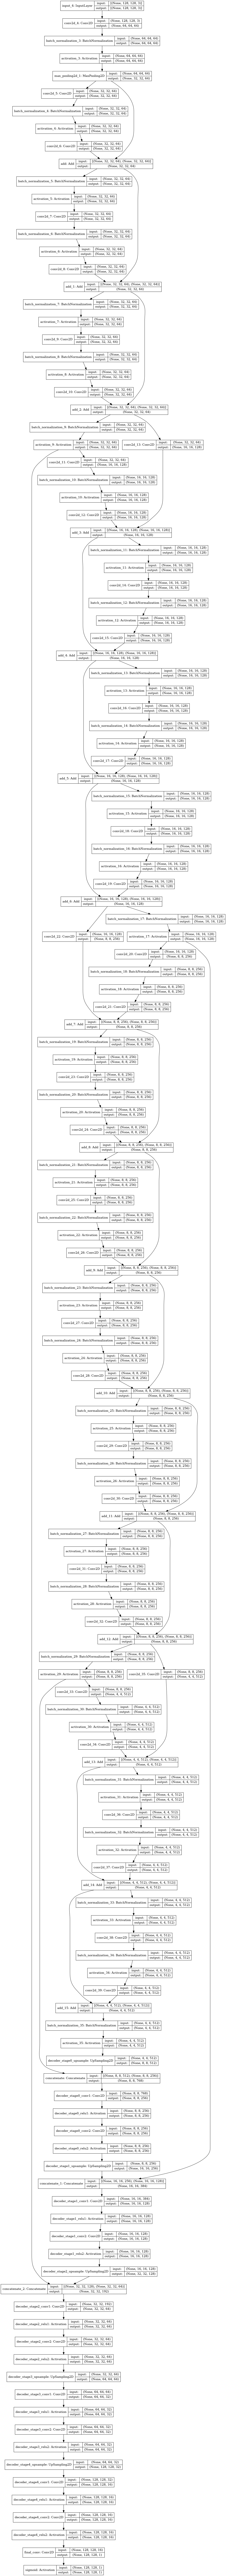

In [35]:
keras.utils.plot_model(model, show_shapes=True, to_file='resnet35-unet.png')

In [69]:
def ssmi_loss1(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
#     y_true = tf.expand_dims(y_true, -1)
#     y_pred = tf.expand_dims(y_pred, -1)
    ssim = tf.image.ssim(y_true, y_pred, 
                            max_val=10.0, 
                            filter_size=11,
                            filter_sigma=1.5,
                            k1=0.01,
                            k2=0.03)
    loss1 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # loss3 = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    loss2 = tf.reduce_mean(1-ssim)
    return loss2*0.7+loss1*0.3

In [70]:
model.compile(optimizer='adam', loss=ssmi_loss1, metrics=['acc'])

In [71]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tmp/eff_b3")

In [72]:
savebest = tf.keras.callbacks.ModelCheckpoint('./tmp/eff_b3_model',
                                monitor='loss',
                               save_freq='epoch',
                                save_best_only=True)

In [33]:
# Test Import module

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
# model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1, callbacks=[tensorboard_callback, savebest])

Epoch 1/2
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - ETA: 0s - loss: 0.2396 - acc: 3.4797e-09(None, 128, 128, 1)
(None, 128, 128, 1)
1268/1268 [==============================] - 393s 230ms/step - loss: 0.2394 - acc: 3.4781e-09 - val_loss: 0.0619 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34-2/assets
Epoch 2/2
1268/1268 [==============================] - 136s 106ms/step - loss: 0.0402 - acc: 3.3852e-09 - val_loss: 0.0594 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/resnet34-2/assets


In [83]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
model.fit(train_ds, validation_data=val_ds, epochs=200, verbose=1, callbacks=[tensorboard_callback, savebest])

Epoch 1/200
1268/1268 [==============================] - 258s 202ms/step - loss: 0.0100 - acc: 1.5051e-09 - val_loss: 0.1265 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/eff_b3_model/assets
Epoch 2/200
1268/1268 [==============================] - 256s 200ms/step - loss: 0.0092 - acc: 1.5051e-09 - val_loss: 0.0705 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/eff_b3_model/assets
Epoch 3/200
1268/1268 [==============================] - 255s 199ms/step - loss: 0.0078 - acc: 1.5051e-09 - val_loss: 0.0891 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/eff_b3_model/assets
Epoch 4/200
1268/1268 [==============================] - 256s 200ms/step - loss: 0.0068 - acc: 1.5051e-09 - val_loss: 0.0742 - val_acc: 0.0000e+00
INFO:tensorflow:Assets written to: ./tmp/eff_b3_model/assets
Epoch 5/200
1268/1268 [==============================] - 256s 200ms/step - loss: 0.0064 - acc: 1.5051e-09 - val_loss: 0.1175 - val_acc: 0.0000e+00
INFO:tensorflow:Asset

In [84]:
test_img = '/tmp/data/nyu2_test/00016_colors.png'
depth_img = '/tmp/data/nyu2_test/00016_depth.png'

In [85]:
import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img)

In [86]:
dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)

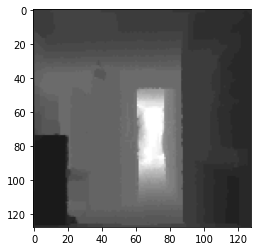

In [87]:
plt.imshow(dimg)

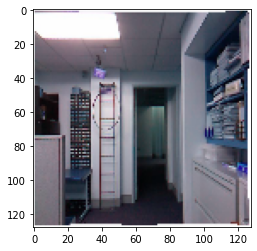

In [88]:
plt.imshow(img)

In [89]:
img.shape

(128, 128, 3)

In [90]:
preds = model.predict(np.expand_dims(img / 255.0, axis=0))

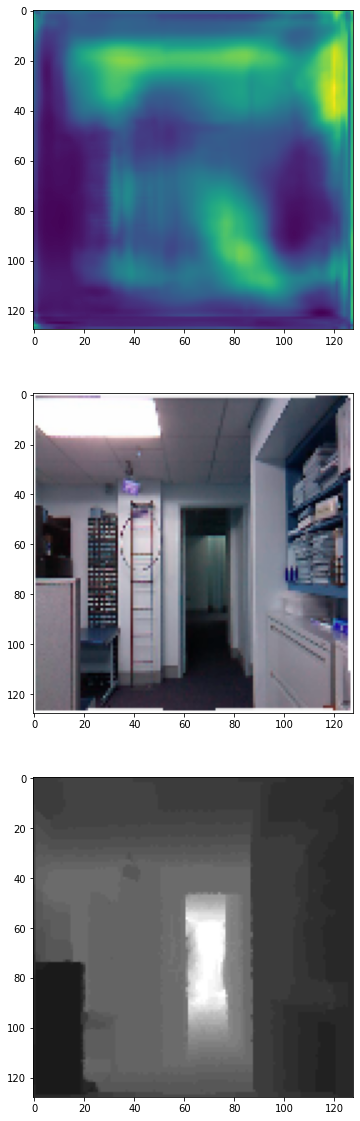

In [91]:
plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

## Running Predict on DIML single image as test

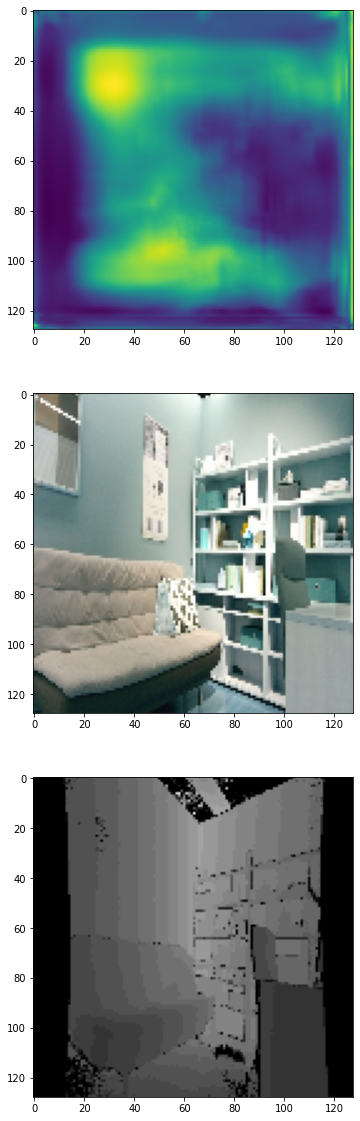

In [92]:
test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_00_160216_122936_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_00_160216_122936_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg)

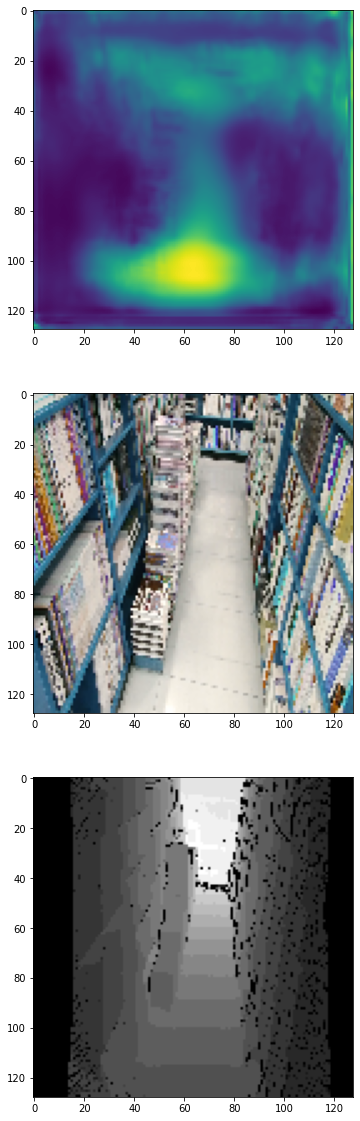

In [93]:
# in_03_160317_172443_c.png

test_img = '/tmp/Notebooks/ssuwal/train-data/rgb/in_03_160317_172443_c.png'
depth_img = '/tmp/Notebooks/ssuwal/train-data/depth/in_03_160317_172443_depth_raw.png'

import cv2
img =cv2.imread(test_img)
img = cv2.resize(img, (128, 128))
# img = img/float(255.0)
img = np.array(img) / 255.0

dimg =cv2.imread(depth_img)
dimg = cv2.resize(dimg, (128, 128))
dimg = dimg/np.max(dimg)
dimg = np.array(dimg)


preds = model.predict(np.expand_dims(img, axis=0))


plt.figure(figsize=(20, 20))
prds1 = np.reshape(preds[0], newshape=(preds[0].shape[0]*preds[0].shape[1]))
plt.subplot(3,1,1)
plt.imshow(np.reshape(prds1, newshape=(128, 128))*255)
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(dimg,  cmap=plt.cm.viridis)

In [94]:
model.save('../eff_b3_unet.h5')

In [32]:
import keras
model = keras.models.load_model('./tmp/resnet34')

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,3,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]

In [ ]:
modelsav